In [ ]:
pip install yfinance pandas matplotlib seaborn

[*********************100%***********************]  3 of 3 completed

Testing SMA windows: [5, 10, 15, 20, 25, 30, 35, 40, 45]
  Calculating for SMA window: 5...
  Calculating for SMA window: 10...
  Calculating for SMA window: 15...
  Calculating for SMA window: 20...
  Calculating for SMA window: 25...
  Calculating for SMA window: 30...
  Calculating for SMA window: 35...
  Calculating for SMA window: 40...
  Calculating for SMA window: 45...


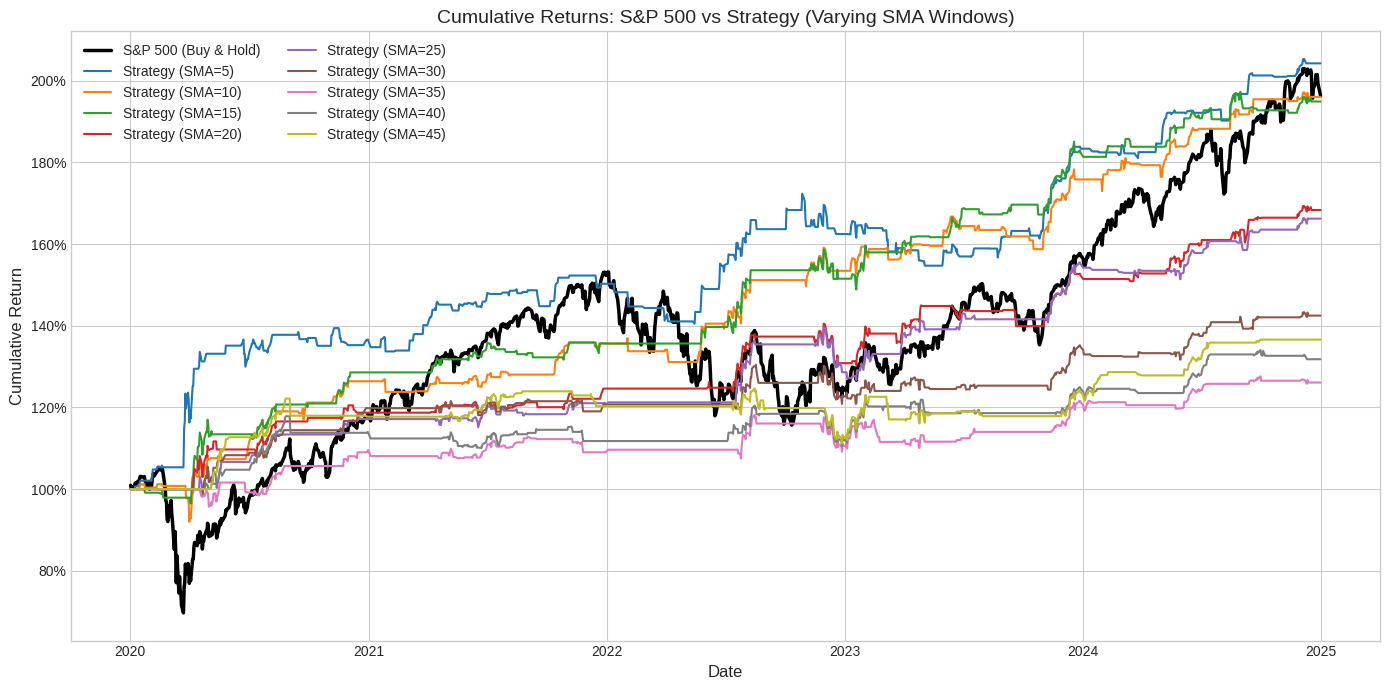

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

tickers = ['SPY', '^VIX', 'TLT']
start_date = '2019-12-31'
end_date = '2025-01-01'
sma_windows_to_test = range(5, 50, 5)

print(f"Testing SMA windows: {list(sma_windows_to_test)}")

# --- Download Data ---
# Download data once before the loop
base_data = yf.download(tickers, start=start_date, end=end_date)['Close']

# --- Prepare Base Data ---
if isinstance(base_data.columns, pd.MultiIndex):
    base_data.columns = base_data.columns.get_level_values(1)
base_data.rename(columns={'SPY': 'SPY', '^VIX': 'VIX', 'TLT': 'TLT'}, inplace=True)

# Calculate SPY returns and cumulative returns once
base_data['SPY_Returns'] = base_data['SPY'].pct_change()[1:]
base_data['SPY_Cumulative'] = (1 + base_data['SPY_Returns']).cumprod()

# Dictionary to store results for each window size
strategy_results = {}

# --- Loop Through SMA Windows ---
for sma_window in sma_windows_to_test:
    print(f"  Calculating for SMA window: {sma_window}...")
    # Create a copy for this iteration to avoid modifying base_data
    data = base_data[['SPY', 'VIX', 'TLT', 'SPY_Returns']].copy()

    # --- Calculate Moving Averages ---
    data['VIX_SMA'] = data['VIX'].rolling(window=sma_window).mean()
    data['TLT_SMA'] = data['TLT'].rolling(window=sma_window).mean()

    # --- Calculate Strategy Signals using SMAs ---
    data['VIX_SMA_Falling'] = data['VIX_SMA'].diff() < 0
    data['TLT_SMA_Rising'] = data['TLT_SMA'].diff() > 0

    # Combine conditions, handling NaNs
    data['Signal'] = np.where(
        data['VIX_SMA_Falling'].fillna(False) & data['TLT_SMA_Rising'].fillna(False),
        1,
        0
    )

    # Shift signal for position (avoid lookahead)
    data['Position'] = data['Signal'].shift(1).fillna(0) # Fill NaN from shift

    # --- Calculate Strategy Returns ---
    data['Strategy_Returns'] = data['SPY_Returns'] * data['Position']
    # No need to fillna Strategy_Returns again as SPY_Returns and Position are handled

    # --- Calculate Cumulative Strategy Returns ---
    data['Strategy_Cumulative'] = (1 + data['Strategy_Returns']).cumprod()

    # --- Store Results ---
    # Store the cumulative return series, keyed by the window size
    strategy_results[sma_window] = data['Strategy_Cumulative']


# --- Plot Results ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 7)) # Slightly wider figure

# Plot S&P 500 Buy & Hold
plt.plot(base_data.index, base_data['SPY_Cumulative'] * 100, label='S&P 500 (Buy & Hold)', linewidth=2.5, color='black')

# Plot each strategy result
for sma_window, cumulative_returns in strategy_results.items():
    plt.plot(cumulative_returns.index, cumulative_returns * 100, label=f'Strategy (SMA={sma_window})', linewidth=1.5)

plt.title('Cumulative Returns: S&P 500 vs Strategy (Varying SMA Windows)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)

# Format Y-axis as percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100.0))

plt.legend(fontsize=10, ncol=2) # Adjust legend parameters if many lines
plt.grid(True)
plt.tight_layout()
plt.show()